In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import itertools
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio 
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio.mask
from pyproj import CRS
import os
os.environ['USE_PYGEOS'] = '0'

from util.files import *
from util.const import *

In [3]:
# FIPS will be passed in as an argument, one day...
FIPS = '34007'
# STATE ABBR and NATION will be derived from FIPS, one day...
STATEABBR = 'NJ'
NATION = 'US'

# Link NSI with Depth Grids

In [6]:
# Dictionary to store the depth grids
dg_dict = {}
# Loop through RPs and the percentiles
# Probably should rename directories accordingly
# since there the boostrapped percentile
# is useful information 
for rp, pctile in itertools.product(RET_PERS, HAZ_DIRS):
    pct = pctile.split('_')[-1]
    dg_dict['_'.join([pct, rp])] = read_dg(rp, pctile)
    print('Read in ' + rp + ' RP depth grid for ' + pct + ' percentile')

    # Should do the sampling right away. Should not use a dict
    # Should replace a temp dataframe... 

Read in 001 RP depth grid for scenario Lower
Read in 001 RP depth grid for scenario Mid
Read in 001 RP depth grid for scenario Upper
Read in 002 RP depth grid for scenario Lower
Read in 002 RP depth grid for scenario Mid
Read in 002 RP depth grid for scenario Upper
Read in 005 RP depth grid for scenario Lower
Read in 005 RP depth grid for scenario Mid
Read in 005 RP depth grid for scenario Upper
Read in 010 RP depth grid for scenario Lower
Read in 010 RP depth grid for scenario Mid
Read in 010 RP depth grid for scenario Upper
Read in 015 RP depth grid for scenario Lower
Read in 015 RP depth grid for scenario Mid
Read in 015 RP depth grid for scenario Upper
Read in 020 RP depth grid for scenario Lower
Read in 020 RP depth grid for scenario Mid
Read in 020 RP depth grid for scenario Upper
Read in 025 RP depth grid for scenario Lower
Read in 025 RP depth grid for scenario Mid
Read in 025 RP depth grid for scenario Upper
Read in 050 RP depth grid for scenario Lower
Read in 050 RP depth gri

In [7]:
# I want to reproject other files to thet hazard CRS because
# this is the data we want to maintain spatial accuracy with the most
# I might want to clip this to the GC clip boundary since it can
# potentially speed up some code for doing 
# point in raster, etc. 
# For my first pass linking up, I also want to include
# the 5th and 95th percentile grids and just use
# a heuristic approach for estimating the standard deviation
# for a normal distribution
# Get this standard deviation parameter and then use the median
# value as the mean 
# That's all we get from the link NSI with hazard step...
# Then in the ensemble merge step, we sample from
# the spatially varying distribution across all RPs

# To start, let's reproject the NSI to the HAZ_CRS
# Then prepare the coordinates for point in raster checks
nsi = gpd.read_file(join(EXP_DIR_I, FIPS, 'nsi_sf.gpkg'))
nsi_reproj = nsi.to_crs(HAZ_CRS)

In [8]:
# For each depth grid, we will sample from the grid
# by way of a list of coordinates from the reprojected
# nsi geodataframe (this is the fastest way I know to do it)
coords = zip(nsi_reproj['geometry'].x, nsi_reproj['geometry'].y)
coord_list = [(x, y) for x, y in coords]
print('Store NSI coordinates in list')

# We'll store series of fd_id/depth pairs for each return period
# in a list and concat this into a df after iterating
depth_list = []
for rp, dg in dg_dict.items():
    print('Return period: ' + rp)
    # Sample from the depth grid based on structure locations
    # I did some ground truthing in qgis
    # It appears that the sampled values align correctly
    sampled_depths = [x[0] for x in dg.sample(coord_list)]
    print('Sampled depth from grid:')

    # Store the series 
    depths = pd.Series(sampled_depths,
                       index=nsi_reproj['fd_id'],
                       name=rp)
    # Add the series to the list of series
    depth_list.append(depths)
    print('Aligned depths with index of structures in series')

# Concat to dataframe
depth_df = pd.concat(depth_list, axis=1)

Store NSI coordinates in list
Return period: Lower_001
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Mid_001
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Upper_001
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Lower_002
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Mid_002
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Upper_002
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Lower_005
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Mid_005
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Upper_005
Sampled depth from grid:
Aligned depths with index of structures in series
Return period: Lower_010
Sampled depth from grid:
Aligned depths with index 

<Axes: >

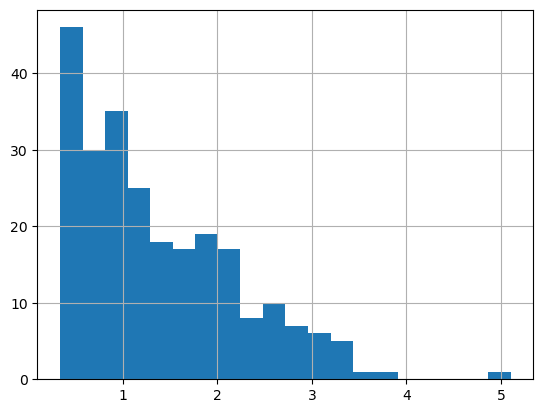

In [9]:
(depth_df[depth_df['Mid_500'] > 0]['Mid_500']*3.218).hist(bins=20)

<Axes: >

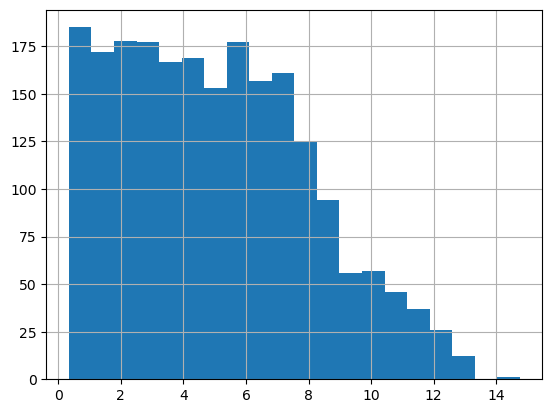

In [10]:
(depth_df[depth_df['Upper_500'] > 0]['Upper_500']*3.218).hist(bins=20)

Text(0.5, 0.98, '500 YR RP Diagnostics')

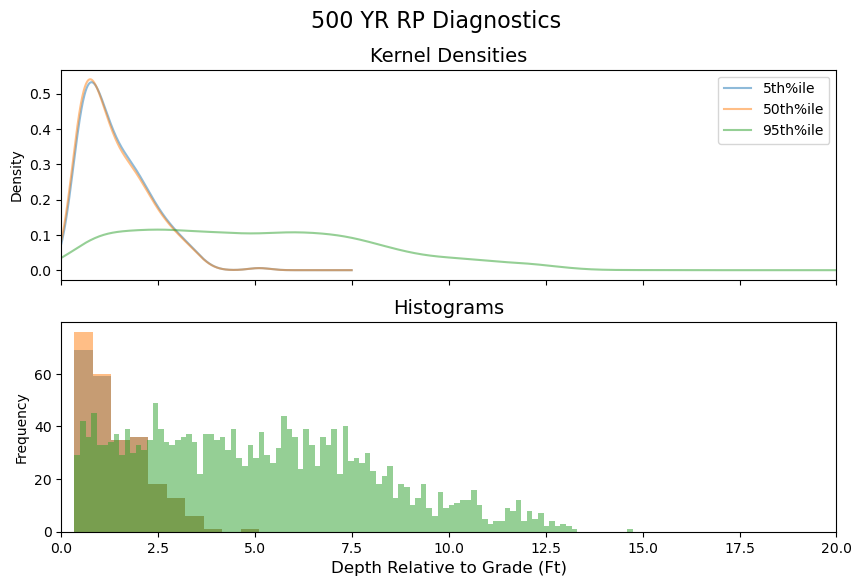

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6),
                       sharex=True,
                       nrows=2)
(depth_df[depth_df['Lower_500'] > 0]['Mid_500']*3.218).plot(kind='kde',
                                                            label='5th%ile',
                                                          ax=ax[0],
                                                          alpha=.5)
(depth_df[depth_df['Mid_500'] > 0]['Mid_500']*3.218).plot(kind='kde',
                                                          label='50th%ile',
                                                          ax=ax[0],
                                                          alpha=.5)
(depth_df[depth_df['Upper_500'] > 0]['Upper_500']*3.218).plot(kind='kde',
                                                              label='95th%ile',
                                                              ax=ax[0],
                                                              alpha=.5)


(depth_df[depth_df['Lower_500'] > 0]['Mid_500']*3.218).plot(kind='hist',
                                                          ax=ax[1],
                                                          alpha=.5)
(depth_df[depth_df['Mid_500'] > 0]['Mid_500']*3.218).plot(kind='hist',
                                                          ax=ax[1],
                                                          alpha=.5)
(depth_df[depth_df['Upper_500'] > 0]['Upper_500']*3.218).plot(kind='hist',
                                                              label='95th%ile',
                                                              ax=ax[1],
                                                              bins=100,
                                                              alpha=.5)

ax[0].legend()
ax[0].set_title('Kernel Densities', size=14)
ax[1].set_title('Histograms', size=14)
ax[0].set_xlim([0, 20])
ax[1].set_xlabel('Depth Relative to Grade (Ft)', size=12)
fig.suptitle("500 YR RP Diagnostics", size=16)

Text(0.5, 0.98, '200 YR RP Diagnostics')

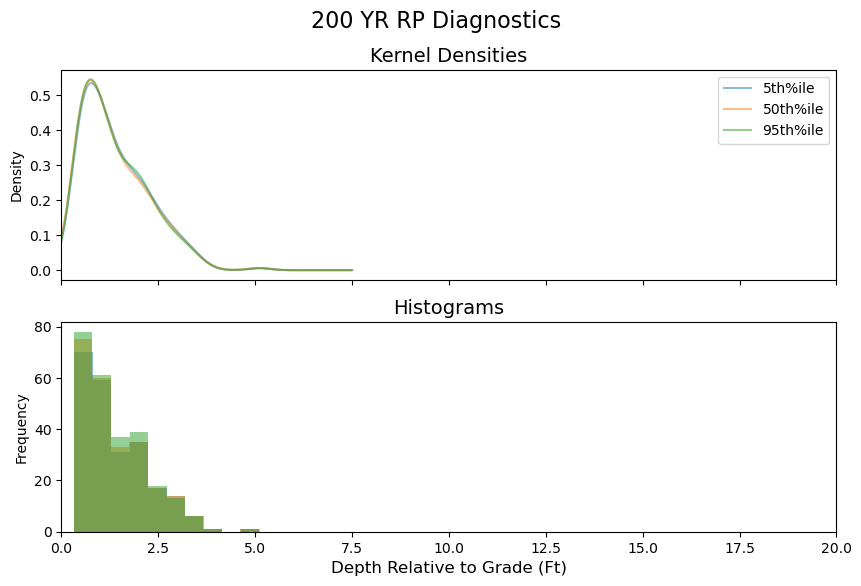

In [41]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6),
                       sharex=True,
                       nrows=2)
(depth_df[depth_df['Lower_200'] > 0]['Mid_200']*3.218).plot(kind='kde',
                                                            label='5th%ile',
                                                          ax=ax[0],
                                                          alpha=.5)
(depth_df[depth_df['Mid_200'] > 0]['Mid_200']*3.218).plot(kind='kde',
                                                          label='50th%ile',
                                                          ax=ax[0],
                                                          alpha=.5)
(depth_df[depth_df['Upper_200'] > 0]['Upper_200']*3.218).plot(kind='kde',
                                                              label='95th%ile',
                                                              ax=ax[0],
                                                              alpha=.5)


(depth_df[depth_df['Lower_200'] > 0]['Mid_200']*3.218).plot(kind='hist',
                                                          ax=ax[1],
                                                          alpha=.5)
(depth_df[depth_df['Mid_200'] > 0]['Mid_200']*3.218).plot(kind='hist',
                                                          ax=ax[1],
                                                          alpha=.5)
(depth_df[depth_df['Upper_200'] > 0]['Upper_200']*3.218).plot(kind='hist',
                                                              label='95th%ile',
                                                              ax=ax[1],
                                                              alpha=.5)

ax[0].legend()
ax[0].set_title('Kernel Densities', size=14)
ax[1].set_title('Histograms', size=14)
ax[0].set_xlim([0, 20])
ax[1].set_xlabel('Depth Relative to Grade (Ft)', size=12)
fig.suptitle("200 YR RP Diagnostics", size=16)

In [42]:
len(depth_df[depth_df['Upper_200'] > 0])

254

In [43]:
len(depth_df[depth_df['Lower_200'] > 0])

234

In [32]:
len(depth_df)

3375